In [61]:
import sqlite3
import pandas as pd
import numpy as np
import pmdarima as pmd
from pathlib import Path
from sklearn.model_selection import train_test_split

In [28]:
cwd = Path.cwd()
parent = cwd.parent
finalDBpath = parent.joinpath("data/database_final.db")


In [29]:
query_unemployment = "SELECT * FROM montly_unemployement_claimant_count_by_lsoa_barnet"
conn = sqlite3.connect(finalDBpath)

unemploymentDF = pd.read_sql(query_unemployment, conn)
unemploymentDF.drop(columns=["index"], inplace=True)

In [30]:
unemploymentDF = unemploymentDF[unemploymentDF["geogcode"] == "Column Total"]
unemploymentDF.dropna(inplace=True)

In [31]:
unemploymentDF["date"] = pd.to_datetime(unemploymentDF["date"])
unemploymentDF = unemploymentDF[unemploymentDF["date"]<"2020"]
unemploymentDF.reset_index(drop=True, inplace=True)

del unemploymentDF["geogcode"]

<Axes: >

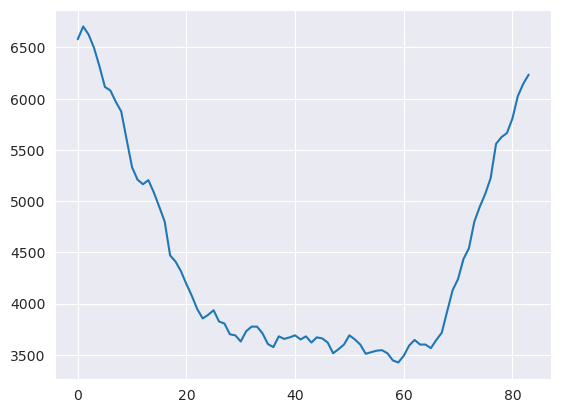

In [32]:
unemploymentDF["value"].plot()

In [44]:
ADF_test = pmd.arima.ADFTest(alpha=0.05)
ADF_test.should_diff(unemploymentDF["value"])

(0.99, True)

In [33]:
trainSize = int(len(unemploymentDF) * .8)


In [34]:
test = unemploymentDF[unemploymentDF.index >= trainSize]
train = unemploymentDF[unemploymentDF.index < trainSize]

In [35]:
train

,date,value
0,2013-01-01,6580.0
1,2013-02-01,6705.0
2,2013-03-01,6625.0
3,2013-04-01,6495.0
4,2013-05-01,6315.0
...,...,...
62,2018-03-01,3645.0
63,2018-04-01,3600.0
64,2018-05-01,3600.0
65,2018-06-01,3565.0


In [45]:
sarima = pmd.auto_arima(train["value"], d=0)

In [46]:
sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   67
Model:               SARIMAX(1, 0, 3)   Log Likelihood                -391.016
Date:                Mon, 19 Jun 2023   AIC                            794.032
Time:                        12:39:04   BIC                            807.260
Sample:                             0   HQIC                           799.267
                                 - 67                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    116.3464    129.532      0.898      0.369    -137.532     370.224
ar.L1          0.9743      0.025     39.049      0.000       0.925       1.023
ma.L1          0.6693      0.148      4.529      0.000       0.380       0.959
ma.L2          0.7360      0.154      4.767      0.000       0.433       1.039
ma.L3          0.2499      0.156      1.602      0.109      -0.056       0.556
sigma2      6337.7306   1016.826      6.233      0.000    4344.788    8330.673
===================================================================================
Ljung-Box (L1) (Q):                   1.33   Jarque-Bera (JB):                 1.31
Prob(Q):                              0.25   Prob(JB):                         0.52
Heteroskedasticity (H):               0.25   Skew:                            -0.16
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [47]:
pred = sarima.predict((len(unemploymentDF)-trainSize))
true = test["value"]

In [48]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error, mean_absolute_percentage_error

In [49]:
rmse = np.sqrt(mean_squared_error(true, pred))
mae = mean_absolute_error(true, pred)
mape = mean_absolute_percentage_error(true, pred)

In [50]:
pd.DataFrame({"RMSE": [rmse],"MAE": [mae],"MAPE": [mape]}, index=["SARIMA"])

,RMSE,MAE,MAPE
SARIMA,1369.507576,1180.167528,0.216447


In [51]:
import xgboost as xgb

In [58]:
wLags = pd.DataFrame()
wLags["value"] = unemploymentDF["value"].copy()
for i in range(12):
    wLags[f"lag_{i+1}"] = wLags["value"].shift(i+1)

In [63]:
wLags.dropna(inplace=True)
y = wLags["value"].copy()
x = wLags.drop(columns= ["value"]).copy()
x_train, x_test, y_train, y_test = train_test_split(x,y)


In [64]:
x_train

,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12
42,3650.0,3690.0,3670.0,3655.0,3680.0,3575.0,3605.0,3710.0,3775.0,3775.0,3730.0,3630.0
14,5205.0,5165.0,5210.0,5330.0,5600.0,5875.0,5970.0,6080.0,6115.0,6315.0,6495.0,6625.0
68,3715.0,3645.0,3565.0,3600.0,3600.0,3645.0,3590.0,3490.0,3425.0,3445.0,3515.0,3545.0
58,3515.0,3545.0,3540.0,3525.0,3510.0,3600.0,3650.0,3690.0,3600.0,3555.0,3515.0,3620.0
44,3620.0,3680.0,3650.0,3690.0,3670.0,3655.0,3680.0,3575.0,3605.0,3710.0,3775.0,3775.0
38,3680.0,3575.0,3605.0,3710.0,3775.0,3775.0,3730.0,3630.0,3690.0,3700.0,3805.0,3825.0
51,3690.0,3600.0,3555.0,3515.0,3620.0,3660.0,3670.0,3620.0,3680.0,3650.0,3690.0,3670.0
29,3700.0,3805.0,3825.0,3935.0,3890.0,3855.0,3945.0,4075.0,4190.0,4315.0,4410.0,4470.0
32,3730.0,3630.0,3690.0,3700.0,3805.0,3825.0,3935.0,3890.0,3855.0,3945.0,4075.0,4190.0
35,3710.0,3775.0,3775.0,3730.0,3630.0,3690.0,3700.0,3805.0,3825.0,3935.0,3890.0,3855.0


In [66]:
xgbModel= xgb.XGBRegressor()
xgbModel.fit(x_train.values, y_train.values)
xgb_pred = xgbModel.predict(x_test.values)

In [70]:
xgb_mape = mean_absolute_percentage_error(y_test.values, xgb_pred)
xgb_mae = mean_absolute_error(y_test.values, xgb_pred)

In [71]:
xgb_mape, xgb_mae

(0.02393732380055648, 97.1915283203125)